**Base Model + Data Augmentation Technique**

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import EfficientNetB4
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

In [ ]:
labels = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Data/')

Mounted at /content/drive/


In [ ]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=128

for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/Data/Research/Process_1', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)


for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/Data/Research/Process_1', 'test', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)

# converted into array

Xtrain = np.array(X_train)
Ytrain = np.array(Y_train)

100%|██████████| 224/224 [00:03<00:00, 71.84it/s] 


In [ ]:
Xtrain.shape

(5761, 128, 128, 3)

In [ ]:
Ytrain.shape

(5761,)

In [ ]:
Xtrain, Ytrain = shuffle(Xtrain, Ytrain, random_state=42)

In [ ]:
xtrain,xtest, Ytrain,ytest = train_test_split(Xtrain, Ytrain,test_size=0.1, random_state=42)

In [ ]:
xtrain.shape

(5184, 128, 128, 3)

In [ ]:
Ytrain

array(['Non_Demented', 'Non_Demented', 'Non_Demented', ...,
       'Very_Mild_Demented', 'Very_Mild_Demented', 'Very_Mild_Demented'],
      dtype='<U18')

In [ ]:
xtest.shape

(577, 128, 128, 3)

In [ ]:
ytrain_new = []
ytest_new = []

for i in Ytrain:
    ytrain_new.append(labels.index(i))#Converting String Label to integer i.e

ytrain = to_categorical(ytrain_new) #Converts a class vector (integers) to binary class matrix

for i in ytest:
    ytest_new.append(labels.index(i))

ytest = to_categorical(ytest_new)

In [ ]:
ytrain.shape

(5184, 4)

In [ ]:
ytest.shape

(577, 4)

In [ ]:
efficientnetB4= EfficientNetB4(include_top=False,weights='imagenet',input_shape=(image_size, image_size, 3))

71686520/71686520 [==============================] - 3s 0us/step


In [ ]:
# Output of model

model = efficientnetB4.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB4.input, outputs=model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 128, 128, 3)  0           ['normalization[0][0]']      

In [ ]:
model.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
filepath = './inception_v4.hdf5'

In [ ]:
tf.keras.callbacks.ModelCheckpoint(
filepath,
monitor = 'val_loss',
verbose = 0,
save_best_only  = False,
save_weights_only = False,
mode = 'auto',
save_freq='epoch',
options=None,
initial_value_threshold=None
 )

In [ ]:
tensorBoard = TensorBoard(log_dir="logs")
checkPoint = ModelCheckpoint("efficientNetB4.h5",
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                             factor=0.3,
                             patience=2,
                             verbose=1,
                             mode='auto',
                            min_delta=0.001)

**Data Augmentation**

*Adding Noise, Radom Brightness*

In [ ]:
import random
import numpy as np
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
#datagen = ImageDataGenerator(brightness_range=[0.2,1.0])
datagen = ImageDataGenerator(brightness_range=[0.2,1.0], preprocessing_function=add_noise)

In [ ]:
it_train = datagen.flow(xtrain, ytrain, batch_size=64)

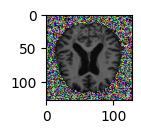

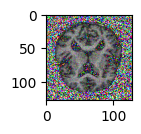

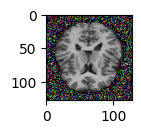

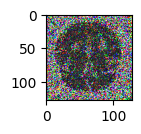

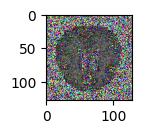

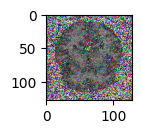

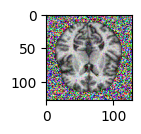

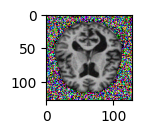

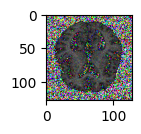

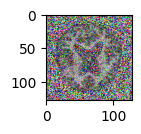

In [ ]:
# generate samples and plot
for i in range(10):
  pyplot.subplot(2, 5, 1 + i)
  batch = it_train.next()
  image = batch[0].astype('uint8')
  pyplot.imshow(image[i])
  pyplot.show()

*Train the model*

In [ ]:
history = model.fit(it_train,
                    epochs=20,
                    validation_data=(xtest,ytest),
                    verbose=1,
                    callbacks=[tensorBoard, checkPoint, reduce_lr])

Epoch 1/20
81/81 [==============================] - ETA: 0s - loss: 1.0390 - accuracy: 0.5039

81/81 [==============================] - 136s 491ms/step - loss: 1.0390 - accuracy: 0.5039 - val_loss: 1.0866 - val_accuracy: 0.4437 - lr: 0.0010
Epoch 2/20
81/81 [==============================] - ETA: 0s - loss: 0.8482 - accuracy: 0.5837

81/81 [==============================] - 36s 437ms/step - loss: 0.8482 - accuracy: 0.5837 - val_loss: 0.8068 - val_accuracy: 0.6343 - lr: 0.0010
Epoch 3/20
81/81 [==============================] - ETA: 0s - loss: 0.7152 - accuracy: 0.6719

81/81 [==============================] - 35s 433ms/step - loss: 0.7152 - accuracy: 0.6719 - val_loss: 1.2485 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 4/20
81/81 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.7728

81/81 [==============================] - 36s 436ms/step - loss: 0.5364 - accuracy: 0.7728 - val_loss: 0.7329 - val_accuracy: 0.7851 - lr: 0.0010
Epoch 5/20
81/81 [==============================] - ETA: 0s - loss: 0.3971 - accuracy: 0.8401

81/81 [==============================] - 35s 435ms/step - loss: 0.3971 - accuracy: 0.8401 - val_loss: 0.3224 - val_accuracy: 0.8995 - lr: 0.0010
Epoch 6/20
81/81 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.8937

81/81 [==============================] - 35s 435ms/step - loss: 0.2734 - accuracy: 0.8937 - val_loss: 0.4584 - val_accuracy: 0.8596 - lr: 0.0010
Epoch 7/20
81/81 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.9172

81/81 [==============================] - 35s 435ms/step - loss: 0.2154 - accuracy: 0.9172 - val_loss: 0.1694 - val_accuracy: 0.9359 - lr: 0.0010
Epoch 8/20
81/81 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9331

81/81 [==============================] - 35s 435ms/step - loss: 0.1710 - accuracy: 0.9331 - val_loss: 0.0822 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 9/20
81/81 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9390

81/81 [==============================] - 35s 435ms/step - loss: 0.1642 - accuracy: 0.9390 - val_loss: 0.0613 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 10/20
81/81 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9516

81/81 [==============================] - 35s 435ms/step - loss: 0.1280 - accuracy: 0.9516 - val_loss: 0.1094 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 11/20
81/81 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9601

81/81 [==============================] - 35s 435ms/step - loss: 0.1107 - accuracy: 0.9601 - val_loss: 0.0964 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 12/20
81/81 [==============================] - ETA: 0s - loss: 0.1125 - accuracy: 0.9597

81/81 [==============================] - 35s 435ms/step - loss: 0.1125 - accuracy: 0.9597 - val_loss: 0.0766 - val_accuracy: 0.9705 - lr: 0.0010
Epoch 13/20
81/81 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.9589

81/81 [==============================] - 35s 435ms/step - loss: 0.1155 - accuracy: 0.9589 - val_loss: 0.1002 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 14/20
81/81 [==============================] - ETA: 0s - loss: 0.0953 - accuracy: 0.9662

81/81 [==============================] - 35s 435ms/step - loss: 0.0953 - accuracy: 0.9662 - val_loss: 0.0169 - val_accuracy: 0.9965 - lr: 0.0010
Epoch 15/20
81/81 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9713

81/81 [==============================] - 35s 434ms/step - loss: 0.0785 - accuracy: 0.9713 - val_loss: 0.0971 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 16/20
81/81 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.9711

81/81 [==============================] - 35s 435ms/step - loss: 0.0812 - accuracy: 0.9711 - val_loss: 0.0857 - val_accuracy: 0.9809 - lr: 0.0010
Epoch 17/20
81/81 [==============================] - ETA: 0s - loss: 0.0772 - accuracy: 0.9724

81/81 [==============================] - 35s 435ms/step - loss: 0.0772 - accuracy: 0.9724 - val_loss: 0.0488 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 18/20
81/81 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9749

81/81 [==============================] - 35s 435ms/step - loss: 0.0649 - accuracy: 0.9749 - val_loss: 0.0402 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 19/20
81/81 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9761

81/81 [==============================] - 35s 435ms/step - loss: 0.0651 - accuracy: 0.9761 - val_loss: 0.0281 - val_accuracy: 0.9913 - lr: 0.0010
Epoch 20/20
81/81 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9755

81/81 [==============================] - 35s 436ms/step - loss: 0.0668 - accuracy: 0.9755 - val_loss: 0.0413 - val_accuracy: 0.9844 - lr: 0.0010


In [ ]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(ytest, axis=1)
print(classification_report(actual_label, pred))

19/19 [==============================] - 4s 52ms/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        81
           1       1.00      1.00      1.00         8
           2       0.98      1.00      0.99       291
           3       0.98      0.98      0.98       197

    accuracy                           0.98       577
   macro avg       0.99      0.98      0.99       577
weighted avg       0.98      0.98      0.98       577



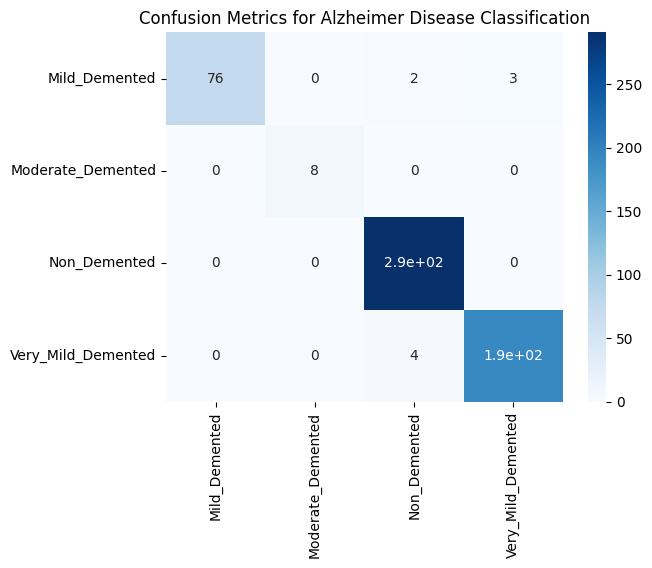

In [ ]:
Cm=confusion_matrix(actual_label,pred)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
           yticklabels=labels,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification")
plt.show()

In [ ]:
def accuracy_and_loss_Plot(modelData):

    fig=plt.figure(figsize=(10,10))

    plt.subplot(221)
    plt.plot(modelData.history["accuracy"], 'bo--',label='accuracy')
    plt.plot(modelData.history["val_accuracy"],'ro--',label='val_accuracy')
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy Information")
    #plt.grid()
    plt.legend()
    plt.tight_layout()

    plt.subplot(222)
    plt.plot(modelData.history["loss"], 'bo--',label='loss')
    plt.plot(modelData.history["val_loss"],'ro--',label='val_loss')
    plt.title("Training Data Loss Measurements")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss Information")
    #plt.grid()
    plt.legend()
    plt.tight_layout()

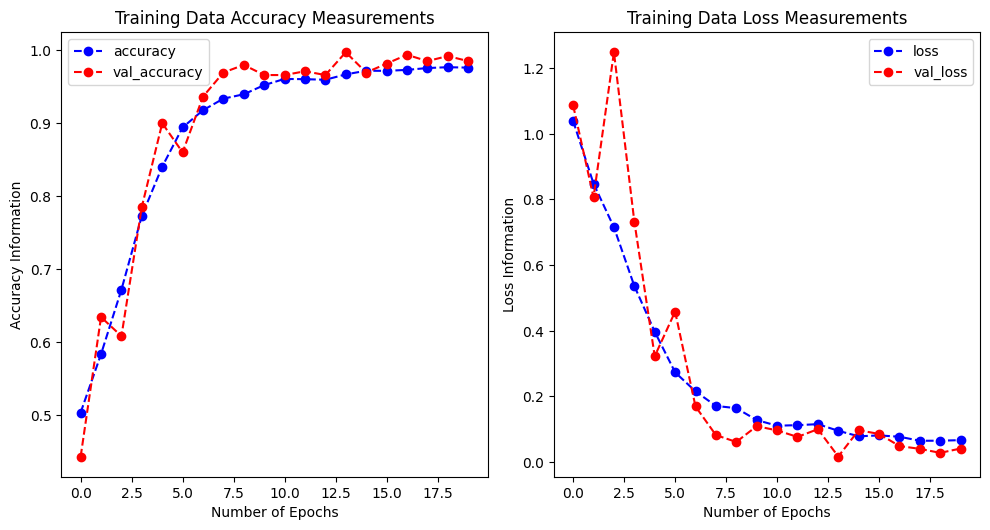

In [ ]:
accuracy_and_loss_Plot(history)

In [ ]:
import cv2

In [ ]:
for i in X_train:
  cv2.rectangle(i, (70, 70), (150, 160), (255, 0, 0), 2)

ValueError: ignored

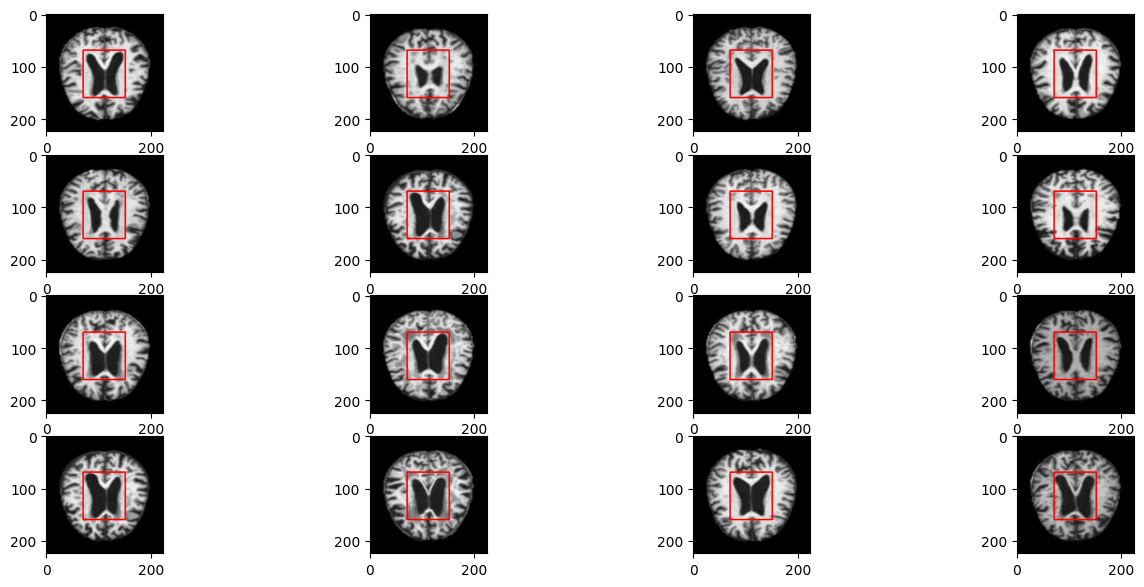

In [ ]:
plt.rcParams['figure.figsize'] = [16,7]

for idx,X_train in enumerate(X_train):
  plt.subplot(4,4,idx+1)
  plt.imshow(X_train)
plt.show()

In [ ]:
filepath = './inception_bbox_v6.hdf5'

In [ ]:
efficientnetB4= EfficientNetB4(include_top=False,weights='imagenet',input_shape=(image_size, image_size, 3))

In [ ]:
# Output of model

model = efficientnetB4.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB4.input, outputs=model)

In [ ]:
model.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
tf.keras.callbacks.ModelCheckpoint(
filepath,
monitor = 'val_loss',
verbose = 0,
save_best_only  = False,
save_weights_only = False,
mode = 'auto',
save_freq='epoch',
options=None,
initial_value_threshold=None
 )

In [ ]:
tensorBoard = TensorBoard(log_dir="logs")
checkPoint = ModelCheckpoint("efficientNetB4.h5",
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                             factor=0.3,
                             patience=2,
                             verbose=1,
                             mode='auto',
                            min_delta=0.001)

In [ ]:
history = model.fit(xtrain,
                    ytrain,
                    batch_size=32,
                    validation_split=0.1,
                    epochs=20,
                    verbose=1,
                    callbacks=[tensorBoard, checkPoint, reduce_lr])

Epoch 1/20
146/146 [==============================] - ETA: 0s - loss: 0.8823 - accuracy: 0.6079

146/146 [==============================] - 121s 240ms/step - loss: 0.8823 - accuracy: 0.6079 - val_loss: 1.0499 - val_accuracy: 0.6224 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.8223

146/146 [==============================] - 32s 221ms/step - loss: 0.4714 - accuracy: 0.8223 - val_loss: 1.5479 - val_accuracy: 0.5857 - lr: 0.0010
Epoch 3/20
146/146 [==============================] - ETA: 0s - loss: 0.2387 - accuracy: 0.9115

146/146 [==============================] - 33s 223ms/step - loss: 0.2387 - accuracy: 0.9115 - val_loss: 0.2271 - val_accuracy: 0.9152 - lr: 0.0010
Epoch 4/20
146/146 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9558

146/146 [==============================] - 33s 225ms/step - loss: 0.1271 - accuracy: 0.9558 - val_loss: 0.2622 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 5/20
146/146 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9636

146/146 [==============================] - 33s 226ms/step - loss: 0.1064 - accuracy: 0.9636 - val_loss: 0.3181 - val_accuracy: 0.8825 - lr: 0.0010
Epoch 6/20
146/146 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9734

146/146 [==============================] - 33s 227ms/step - loss: 0.0781 - accuracy: 0.9734 - val_loss: 0.5060 - val_accuracy: 0.8478 - lr: 0.0010
Epoch 7/20
146/146 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9792

146/146 [==============================] - 33s 227ms/step - loss: 0.0633 - accuracy: 0.9792 - val_loss: 0.1634 - val_accuracy: 0.9557 - lr: 0.0010
Epoch 8/20
146/146 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9777

146/146 [==============================] - 33s 227ms/step - loss: 0.0660 - accuracy: 0.9777 - val_loss: 0.1906 - val_accuracy: 0.9268 - lr: 0.0010
Epoch 9/20
146/146 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9788

146/146 [==============================] - 33s 227ms/step - loss: 0.0629 - accuracy: 0.9788 - val_loss: 1.5553 - val_accuracy: 0.7418 - lr: 0.0010
Epoch 10/20
146/146 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.9818

146/146 [==============================] - 33s 227ms/step - loss: 0.0537 - accuracy: 0.9818 - val_loss: 0.0576 - val_accuracy: 0.9788 - lr: 0.0010
Epoch 11/20
146/146 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9876

146/146 [==============================] - 33s 227ms/step - loss: 0.0350 - accuracy: 0.9876 - val_loss: 0.1819 - val_accuracy: 0.9461 - lr: 0.0010
Epoch 12/20
146/146 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9805

146/146 [==============================] - 33s 227ms/step - loss: 0.0546 - accuracy: 0.9805 - val_loss: 0.5735 - val_accuracy: 0.8112 - lr: 0.0010
Epoch 13/20
146/146 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9822

146/146 [==============================] - 33s 227ms/step - loss: 0.0449 - accuracy: 0.9822 - val_loss: 0.0914 - val_accuracy: 0.9730 - lr: 0.0010
Epoch 14/20
146/146 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.9826

146/146 [==============================] - 33s 227ms/step - loss: 0.0493 - accuracy: 0.9826 - val_loss: 0.2024 - val_accuracy: 0.9499 - lr: 0.0010
Epoch 15/20
146/146 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9831

146/146 [==============================] - 33s 227ms/step - loss: 0.0508 - accuracy: 0.9831 - val_loss: 0.1989 - val_accuracy: 0.9306 - lr: 0.0010
Epoch 16/20
146/146 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9874

146/146 [==============================] - 33s 227ms/step - loss: 0.0386 - accuracy: 0.9874 - val_loss: 0.2338 - val_accuracy: 0.9441 - lr: 0.0010
Epoch 17/20
146/146 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9899

146/146 [==============================] - 33s 227ms/step - loss: 0.0262 - accuracy: 0.9899 - val_loss: 0.5116 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 18/20
146/146 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9901

146/146 [==============================] - 33s 227ms/step - loss: 0.0304 - accuracy: 0.9901 - val_loss: 0.0651 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 19/20
146/146 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9934

146/146 [==============================] - 33s 227ms/step - loss: 0.0179 - accuracy: 0.9934 - val_loss: 0.0679 - val_accuracy: 0.9884 - lr: 0.0010
Epoch 20/20
146/146 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9959

146/146 [==============================] - 33s 227ms/step - loss: 0.0124 - accuracy: 0.9959 - val_loss: 0.1550 - val_accuracy: 0.9615 - lr: 0.0010


In [ ]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(ytest, axis=1)
print(classification_report(actual_label, pred))

19/19 [==============================] - 4s 53ms/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        81
           1       0.89      1.00      0.94         8
           2       0.99      0.98      0.98       291
           3       0.99      0.92      0.95       197

    accuracy                           0.96       577
   macro avg       0.92      0.97      0.95       577
weighted avg       0.97      0.96      0.96       577



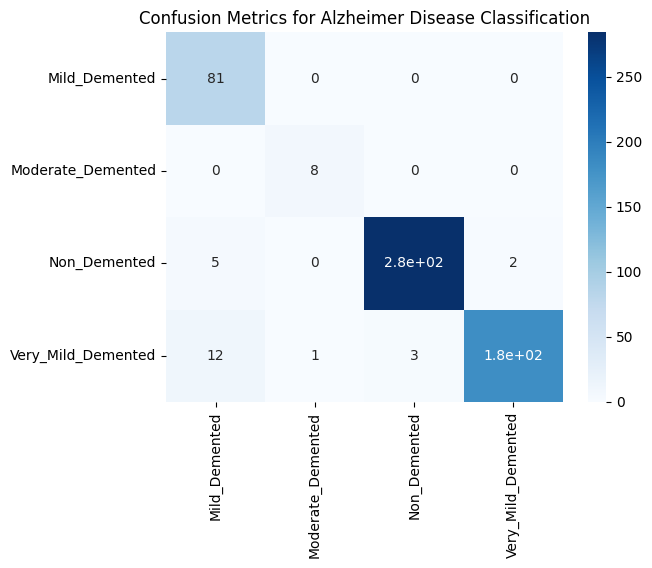

In [ ]:
Cm=confusion_matrix(actual_label,pred)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
           yticklabels=labels,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification")
plt.show()

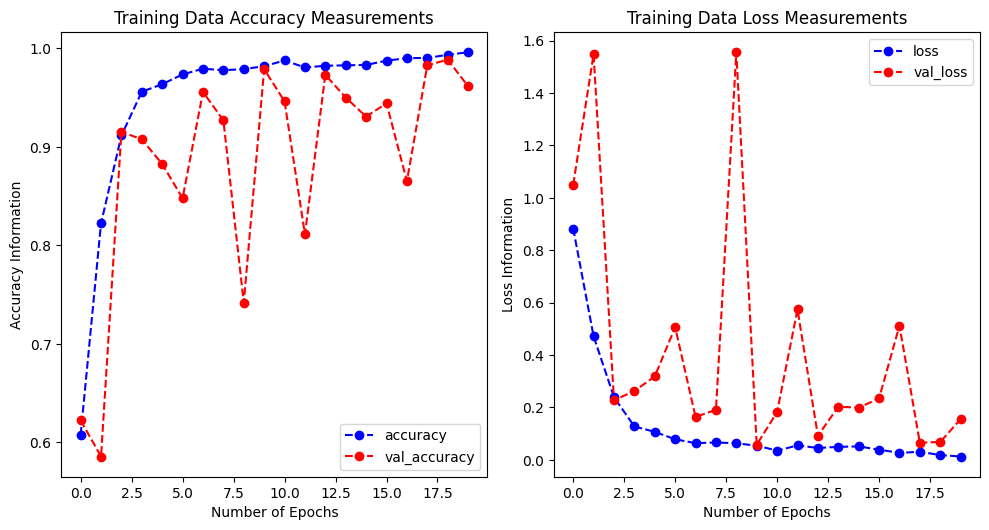

In [ ]:
accuracy_and_loss_Plot(history)